In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("eq_1960_2022.csv")

In [3]:
data.head()

,time,latitude,longitude,depth,mag
0,2021-12-01,35.2280,141.4204,10.00,4.7
1,2021-12-01,35.2774,141.5336,10.00,4.7
2,2021-12-01,33.7690,137.1036,362.75,4.0
3,2021-12-01,35.2014,141.4165,10.00,4.5
4,2021-12-01,35.1430,141.3281,10.00,4.9


## Data Preprocessing

### Division en zones

On récupère le code précèdent

In [4]:
from collections import namedtuple

Coords = namedtuple("Coords", "lat_min lat_max lon_min lon_max")

In [5]:
zones = {"A": Coords(41, 46, 140, 146), "B": Coords(37, 41, 138, 142), "C": Coords(34, 37, 137, 141), "D": Coords(33, 37, 133, 137), "E": Coords(31, 36, 129, 133), "F": Coords(38, 41, 142, 144), "G": Coords(36, 38, 141, 143)}

def to_5_zone(lat: float, lon: float):
    """Convert coordinates to a zone number according to the map arrangement above"""
    for zone, coord in zones.items():
        if (coord.lat_min <= lat <= coord.lat_max) & (coord.lon_min <= lon <= coord.lon_max):
            return zone
    return 0


In [6]:
data["zone"] = data.apply(lambda x: to_5_zone(x['latitude'], x['longitude']), axis=1)

Pour simplifier, nous utiliserons 5 zones découpées ainsi : trois zones en zone verte et 2 en zone bleues (cf code d'Ibrahima).  
Ces zones sont celles qui nous intéressent le plus car directement situé sur l'île. Cependant, nous utiliserons également 2 zones supplémentaires dans l'océan pacifique où se trouve le plus grand nombre d'EQ.  
  
![carte_japon.jpg](carte_japon.jpg)

zone A : île nord (Hokkaido) 41°N à 46°N et 140°E à 146°E  
zone B : Tohoku district, 37°N à 41°N et 138°E à 142°E  
zone C : Kanto et Chubu districts, 34°N à 37°N et 137°E à 141°E  
zone D : Kinki, Chugoku et Shikoku districts, 33°N à 37°N et 133°E à 137°E  
zone E : Kyushu district, 31°N à 36°N et 129°E à 133°E  
zone F : 38°N à 41°N et 142°E à 144°E  
zone G : 36°N à 38°N et 141°E à 143°E

In [7]:
data.head()

,time,latitude,longitude,depth,mag,zone
0,2021-12-01,35.2280,141.4204,10.00,4.7,0
1,2021-12-01,35.2774,141.5336,10.00,4.7,0
2,2021-12-01,33.7690,137.1036,362.75,4.0,0
3,2021-12-01,35.2014,141.4165,10.00,4.5,0
4,2021-12-01,35.1430,141.3281,10.00,4.9,0


In [8]:
data.zone.value_counts()

0    14129
C     4334
A     3928
F     3589
B     3170
G     3039
E      989
D      890
Name: zone, dtype: int64

In [9]:
data[data.mag >= 4.5].zone.value_counts()

0    7659
F    2284
C    2071
A    2018
B    1721
G    1675
E     528
D     302
Name: zone, dtype: int64

On va s'intéresser uniquement au sinistre de mag >= 4.5 dans les zones précèdentes afin de faire de la prédiction en fréquence

In [10]:
df = data[(data.mag >= 4.5) & (data.zone != 0)]

In [11]:
df["time"] = pd.to_datetime(df.time)

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_20524/2159877504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df.time)


In [79]:
df

,time,latitude,longitude,depth,mag,zone
13,2021-12-01,36.1875,140.0911,51.68,5.0,C
20,2021-12-02,37.7216,141.7845,57.22,4.8,B
23,2021-12-02,35.5460,139.0340,26.64,4.5,C
24,2021-12-02,45.8325,142.5511,314.40,4.6,A
26,2021-12-03,33.8337,135.0775,12.08,5.2,D
...,...,...,...,...,...,...
34063,1960-03-23,39.1370,143.5980,25.00,5.9,F
34064,1960-03-23,39.1460,143.5640,25.00,5.8,F
34065,1960-03-23,39.2350,143.3030,15.00,6.2,F
34066,1960-02-04,38.6670,143.0140,25.00,6.1,F


On récupère le nombre d'EQ par mois

In [12]:
zone_to_col = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}

def to_full_dataset():
    T = (2022 - 1960) * 12  # nb de mois total
    M = 7  # nb de zones
    X_full = np.zeros((T, M), dtype=np.uint8)  # matrice contenant le nb d'EQ avec en ligne les mois par ordre chronologique et en colonne les zones
    for tup in df.itertuples():
        irow = (tup.time.year - 1960)* 12 + tup.time.month - 1
        icol = zone_to_col[tup.zone]
        X_full[irow, icol] += 1
    
    return X_full

In [13]:
X_full = to_full_dataset()

In [14]:
X_full.shape

(744, 7)

In [22]:
from itertools import product

monthly_ix = pd.to_datetime([f"{y}-{m}" for y, m in product(list(range(1960, 2022)), list(range(1, 13)))])

In [23]:
X_full_pd = pd.DataFrame(X_full, index = monthly_ix, columns=["A", "B", "C", "D", "E", "F", "G"])

In [24]:
X_full_pd

,A,B,C,D,E,F,G
1960-01-01,0,0,0,1,0,0,0
1960-02-01,0,0,0,0,0,1,0
1960-03-01,0,0,0,0,0,10,0
1960-04-01,0,0,0,0,0,0,0
1960-05-01,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2021-08-01,1,2,1,1,0,0,32
2021-09-01,2,6,2,0,2,3,1
2021-10-01,6,1,3,1,1,5,2
2021-11-01,2,3,4,0,2,1,3


In [25]:
X_full_pd.to_csv("monthly_count_1960_2022.csv")

# Model

In [1]:
import pandas as pd
import numpy as np

In [16]:
df = pd.read_csv("monthly_count_1960_2022.csv")

In [17]:
df.rename({"Unnamed: 0": "date"}, axis=1, inplace=True)

In [18]:
df.date = pd.to_datetime(df.date)

In [19]:
df = df.set_index("date")

In [20]:
df.head()

,A,B,C,D,E,F,G
date,,,,,,,
1960-01-01,0,0,0,1,0,0,0
1960-02-01,0,0,0,0,0,1,0
1960-03-01,0,0,0,0,0,10,0
1960-04-01,0,0,0,0,0,0,0
1960-05-01,0,0,0,0,0,0,0


In [24]:
df.loc['1980']

,A,B,C,D,E,F,G
date,,,,,,,
1980-01-01,6,1,0,0,0,0,2
1980-02-01,4,2,2,0,7,1,1
1980-03-01,0,2,2,1,0,1,0
1980-04-01,5,0,0,0,0,2,0
1980-05-01,1,0,1,0,0,1,4
1980-06-01,1,2,8,0,1,1,0
1980-07-01,3,3,0,0,0,1,0
1980-08-01,2,0,1,1,0,1,1
1980-09-01,2,1,6,1,0,1,0


Text(27.25, 0.5, 'Number of EQ with $M_c \\geq 4.5$')

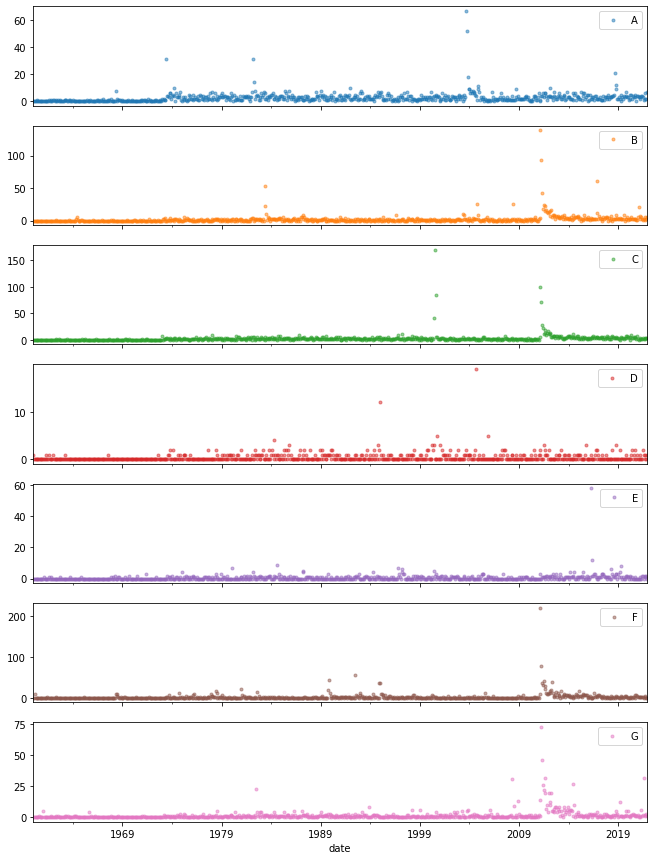

In [29]:
import matplotlib.pyplot as plt

cols_plot = ["A", "B", "C", "D", "E", "F", "G"]
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 15), subplots=True)
ax.set_ylabel('Number of EQ with $M_c \geq 4.5$')

On sépare les données en train set et test set en prenant les données de 1960 à 2014 pour le train set et le reste pour le test set

In [26]:
X_train = X_full[:55*12]
X_train.shape

(660, 7)

In [27]:
X_test = X_full[55*12:]
X_test.shape

(84, 7)

On va séparer les inputs des outputs. On va utiliser une lookback window de $\tau = 60 \text{ mois}$. On ne prend pas de padding, ce qui veut dire que les inputs commencent à $ t = \tau+ 1 $

In [29]:
def split_input(dataset: np.array, tau: int, padding=False):
    """Convert dataset to input output arrays for time series prediction
    params: dataset: the dataset to perform the split with. Time component in dimension 0
            tau: lookback window ( tau < len(dataset) )
    returns: X, y: input and output array of shape (n - tau - 1, tau, n_features) and (n - tau - 1, n_features)"""
    X, Y = [], []
    n = len(dataset)
    assert tau < n, "tau > len(dataset)"
    assert tau > 0, "padding < 1"

    # without padding
    for i in range(n - tau - 1):
        X.append(dataset[i:i + tau])
        Y.append(dataset[i + tau + 1])
    
    return np.array(X), np.array(Y)


In [30]:
X, y = split_input(X_train, 60)

On obtient bien les dimensions souhaitées : (n_sample, timesteps, n_features)

In [31]:
X.shape

(599, 60, 7)

Pour résumer, $X$ contient donc des matrices de taille (60, 7) avec 60 la taille de la lookback window et 7 le nombre de features (ici les zones).  
On essaiera plus tard d'avoir un nombre de feature en 2D comme first model

## Naïve Model

Avec nos données à disposition, nous faisons face à un problème de multi output regression. De plus les valeurs à prédire doivent êtrepositive et entières, ce qui nous oriente vers une fonction d'activation relu. On utilisera la fonction d'arrondi pour avoir un nombre entier.

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow import keras

n_features = X.shape[2]
n_timesteps = X.shape[1]

model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(n_features, activation='relu'))
model.compile(optimizer='adam', loss='mse')

In [33]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [34]:
model.fit(X, y, epochs=400, verbose=1)

Epoch 1/400


In [130]:
model.predict(X[200:260])

array([[-1.73833801e+02,  8.20789337e+01, -4.23242226e+01,
        -3.33785934e+01,  7.67657471e+00, -4.93609905e+00,
         6.04328575e+01],
       [-1.38313782e+02,  6.21784248e+01, -3.55136757e+01,
        -3.07025700e+01,  5.61041260e+00, -2.00794106e+01,
         4.24145470e+01],
       [-1.08956352e+02,  4.44135323e+01, -3.01298866e+01,
        -2.90660954e+01,  4.45806885e+00, -3.08543129e+01,
         2.56379356e+01],
       [-1.37304504e+02,  5.56313057e+01, -3.61743202e+01,
        -3.12992496e+01,  6.04351807e+00, -1.53591948e+01,
         3.53979454e+01],
       [-2.14834045e+02,  1.04982498e+02, -5.13808632e+01,
        -3.59193649e+01,  8.05389404e+00,  8.93499470e+00,
         8.53264084e+01],
       [-2.01578918e+02,  9.99374542e+01, -4.88056679e+01,
        -3.45721970e+01,  6.63922119e+00, -4.88921404e-02,
         8.16874924e+01],
       [-2.85681458e+02,  1.56479202e+02, -6.44091797e+01,
        -3.96151657e+01,  9.16412354e+00,  2.33453941e+01,
         1.3686328